#Course 02

Convolutional Neural Networks in TensorFlow

##Week 02 : Augumentation

###Lets import the libraries :

In [0]:
# First thing first lets install the libraries :

!pip install tensorflow --upgrade --force-reinstall

'''OR''' 

#!pip install tensorflow==2.0.0-alpha0

###Building the Standard CAT-vs-Dog Classifier :

Let's start with a model that's very effective at learning Cats v Dogs.

It's similar to the previous models that you have used, but I have updated the layers definition. Note that there are now 4 convolutional layers with 32, 64, 128 and 128 convolutions respectively.

Also, this will train for 100 epochs, because I want to plot the graph of loss and accuracy.


In [0]:
# ---------------------------------- get the data ------------------------------------------

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

# ----------------------- unzip the data -------------------------------------------------

import os 
import tensorflow as tf
import zipfile

zipped_folder_path = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zipped_folder_path , 'r')
zip_ref.extractall('/content')
zip_ref.close()


# --------------------------- track the directoriesto for the data under train and test ----------

base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir , 'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')


#------------------------------- Build the model --------------------------------------------------------

model = tf.keras.models.Sequential([ 
                                      
            tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) , activation = 'relu' ,input_shape = (150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(filters = 128 , kernel_size = (3,3) , activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(filters = 128 , kernel_size = (3,3) , activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(units = 512, activation = 'relu'),
            
            tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')

                                   ])



#----------------------- Compile the model -----------------------------------------------
model.compile(
      optimizer = tf.keras.optimizers.RMSprop(lr = 0.001),
      loss = 'binary_crossentropy',
      metrics = ['accuracy'])



#---------------- build the data pipeline --------------------------------------------------

# All images will be rescaled by 1./255
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(
                                                     directory =  train_dir,
                                                     target_size = (150,150),
                                                     batch_size = 20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                     class_mode = 'binary'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
                                                    directory = validation_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20 ,
                                                    class_mode = 'binary' 
)

#-------------- create the callback criteria -----------------------------------

class mycallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if logs.get('accuracy') > 0.999:
      print('\n Reach 99.9% accuracy so stopping it!!!')
      self.model.stop_training = True

callbacks = mycallbacks()

# --------------- now lets train the model ------------------------\\\\

history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = 100,  # 2000 images = batch_size * steps
                                epochs = 100,
                                validation_data = validation_generator,
                                validation_steps = 50,  # 1000 images = batch_size * steps 
                                verbose = 1,
                                callbacks = [callbacks]
                                 
)

--2020-04-01 16:45:20--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   235MB/s    in 0.3s    

2020-04-01 16:45:20 (235 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 12s 116ms/step - loss: 0.7570 - accuracy: 0.5080 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 11s 107ms/s

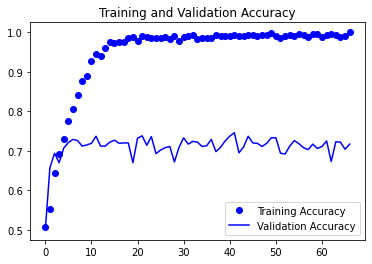

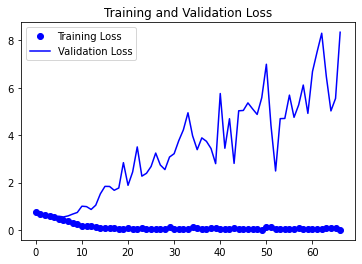

In [0]:
# Now lets analyze the results :

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs, val_acc ,'b' , label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo' , label = 'Training Loss')
plt.plot(epochs, val_loss , 'b' , label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

The Training Accuracy is close to 100%, and the validation accuracy is in the 70%-80% range. This is a great example of **overfitting** -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't. Let's see if we can do better to avoid overfitting -- and one simple method is to augment the images a bit. If you think about it, most pictures of a cat are very similar -- the ears are at the top, then the eyes, then the mouth etc. Things like the distance between the eyes and ears will always be quite similar too. 

What if we tweak with the images to change this up a bit -- rotate the image, squash it, etc.  That's what image augementation is all about. And there's an API that makes it easy...

Now take a look at the ImageGenerator. There are properties on it that you can use to augment the image. 

```
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```
These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


###Building the Augmented CAT-vs-Dog Classifier :

**Lets use the same above code just adding Image Augmentation. Run it to see the impact.**

In [0]:
# ---------------------------------- get the data ------------------------------------------

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

# ----------------------- unzip the data -------------------------------------------------

import os 
import tensorflow as tf
import zipfile

zipped_folder_path = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zipped_folder_path , 'r')
zip_ref.extractall('/content')
zip_ref.close()


# --------------------------- track the directoriesto for the data under train and test ----------

base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir , 'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')


#------------------------------- Build the model --------------------------------------------------------

model = tf.keras.models.Sequential([ 
                                      
            tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) , activation = 'relu' ,input_shape = (150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(filters = 128 , kernel_size = (3,3) , activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(filters = 128 , kernel_size = (3,3) , activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(units = 512, activation = 'relu'),
            
            tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')

                                   ])



#----------------------- Compile the model -----------------------------------------------
model.compile(
      optimizer = tf.keras.optimizers.RMSprop(lr = 0.001),
      loss = 'binary_crossentropy',
      metrics = ['accuracy'])



#---------------- build the data pipeline --------------------------------------------------

'''Change in train data generator after introducin the Augumentation paramerters '''
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                
                              rescale=1./255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest'
                        )

train_generator = train_datagen.flow_from_directory(
                                                     directory =  train_dir,
                                                     target_size = (150,150),
                                                     batch_size = 20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                     class_mode = 'binary'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
                                                    directory = validation_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20 ,
                                                    class_mode = 'binary' 
)

#-------------- create the callback criteria -----------------------------------

class mycallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if logs.get('accuracy') > 0.999:
      print('\n Reach 99.9% accuracy so stopping it!!!')
      self.model.stop_training = True

callbacks = mycallbacks()

# --------------- now lets train the model ------------------------\\\\

history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = 100,  # 2000 images = batch_size * steps
                                epochs = 100,
                                validation_data = validation_generator,
                                validation_steps = 50,  # 1000 images = batch_size * steps 
                                verbose = 1,
                                callbacks = [callbacks]
                                 
)

--2020-04-01 18:37:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.5.208, 2607:f8b0:4026:801::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.5.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   149MB/s    in 0.4s    

2020-04-01 18:37:43 (149 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 [==============================] - 17s 172ms/step - loss: 0.7456 - accuracy: 0.5165 - val_loss: 0.6883 - val_accuracy: 0.5020
Epoch 2/100
100/100 [==============================] - 17s 171ms/step - loss: 0.698

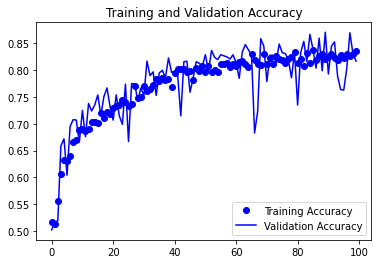

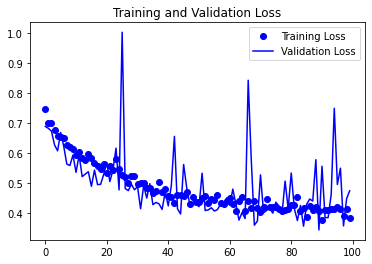

In [0]:
# Now lets analyze the results :

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs, val_acc ,'b' , label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo' , label = 'Training Loss')
plt.plot(epochs, val_loss , 'b' , label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

###Building the Augmented Horse-vs-Human Classifier :

Horses v Humans dataset from Course 1, and take a look to see if the augmentation algorithms will help there! Here’s the code:

**What to Learn : We can learn after running the model with the augmentation feature is that
the image augmentation introduces a random element
to the training images but if
the validation set doesn't have the same randomness,
then its results can fluctuate like this.
So bear in mind that you don't just
need a broad set of images for training,
you also need them for testing or
the image augmentation won't help you very much. **

--2020-04-01 19:11:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.192.112, 2607:f8b0:4026:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.192.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   122MB/s    in 1.2s    

2020-04-01 19:11:01 (122 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-04-01 19:11:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.192.80, 2607:f8b0:4026:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.192.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application

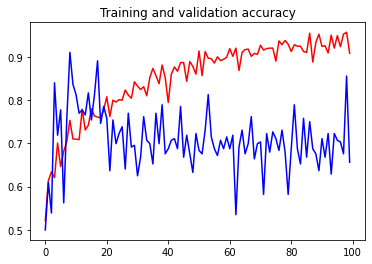

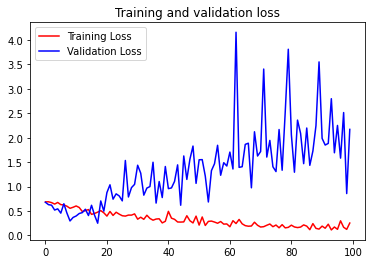

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
  
import os
import zipfile
import tensorflow as tf 

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')




model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])



from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])



from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)



import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



**what we can learn from this is that
the image augmentation introduces a random element
to the training images but if
the validation set doesn't have the same randomness,
then its results can fluctuate like this.
So bear in mind that you don't just
need a broad set of images for training,
you also need them for testing or
the image augmentation won't help you very much.**

###Assignment - Week 02 

Exercise 2 - Cats vs. Dogs using augmentation

Now that you’ve seen Image Augmentation in action, it’s time to go back to the Cats v Dogs full Kaggle Challenge exercise. Last week you built a classifier for Cats v Dogs and trained it for a few epochs. This week I want you to add Augmentation to it, and experiment with different parameters to avoid overfitting. This will likely take a lot of time -- as it requires using the full dataset along with augmentation code to edit the data on-the-fly. The opportunity here is to try hard to get into State-of-the-Art type classification. Experiment with different images it hasn’t before seen, and see if you can get it to correctly classify them! For a particularly challenging image, see if you can get it to classify this one correctly: https://pixabay.com/photos/bed-dog-animals-dogs-pets-relax-1284238/

Lets now build the Cats vs. Dogs classifier using augmentation!

NOTE: Please do not alter any of the provided code in the exercise. Only add your own code where indicated. Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position. Please use the provided epoch values when training. Once you have completed your notebook assignment and received a final score, please save your notebook, run the final cell, and close your Jupyter Workspace. This will help optimize your Jupyter workspace performance for future assessments. Please note that this step will shut down your kernel, so it is important to save your work in advance of completing this step


In [0]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [0]:
# # This code block unzips the full Cats-v-Dogs dataset to /tmp
# # which will create a tmp/PetImages directory containing subdirectories
# # called 'Cat' and 'Dog' (that's how the original researchers structured it)


# path_cats_and_dogs = f"{getcwd()}/../tmp2/cats-and-dogs.zip"
# shutil.rmtree('/tmp')

# local_zip = path_cats_and_dogs
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

In [0]:
code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL


###------------Kaggle Cat vs Dog Dataset ------------------------

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.clo

In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output: for coursera dataset 
# 1500
# 1500

# Expected Output: for kaggle full data set 
# 12501
# 12501

In [0]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    #YOUR CODE GOES HERE
    
    os.chdir('/tmp')
    os.mkdir('cats-v-dogs')
    
    os.chdir('cats-v-dogs')
    os.mkdir('training')
    os.mkdir('testing')
    
    os.chdir('training')
    os.mkdir('cats')
    os.mkdir('dogs')
    
    os.chdir(os.pardir)
    os.chdir('testing')
    os.mkdir('cats')
    os.mkdir('dogs')
    
    os.chdir(os.pardir)
    os.chdir(os.pardir)
    
except OSError:
    pass

In [0]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list


def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    
    # find all the file names in the source
    list_of_files = os.listdir(SOURCE)
    
    
    #find the no of files to be copied 
    no_of_files_to_be_copied_in_training = SPLIT_SIZE*len(list_of_files)
    no_of_files_to_be_copied_in_training = int(no_of_files_to_be_copied_in_training)

    #randomely select those many files:
    files_to_be_copied = random.sample(list_of_files,no_of_files_to_be_copied_in_training)
    remaining_files = [fn for fn in list_of_files if fn not in files_to_be_copied]
    
    for file_name in files_to_be_copied:
        if os.path.getsize(SOURCE+file_name) != 0:
            copyfile(SOURCE+file_name,TRAINING+file_name)
            
    for file_name in remaining_files:
        if os.path.getsize(SOURCE+file_name) != 0:
            copyfile(SOURCE+file_name,TESTING+file_name)
    
    
# YOUR CODE STARTS HERE
# YOUR CODE ENDS HERE



CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output: ----------------Kaggle Data Set ----------------
# 11250
# 11250
# 1250
# 1250

# Expected output: ---------Coursera Data Set ---------------
# 1350
# 1350
# 150
# 150

In [0]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(filters = 16 , kernel_size = (3,3), activation = 'relu', input_shape =(150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    #tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
                                    #tf.keras.layers.MaxPooling2D(2,2),
                           
                                    #tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
                                    #tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(units = 512, activation = 'relu'),

                                    tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')
# YOUR CODE HERE
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

##### NOTE:

In the cell below you **MUST** use a batch size of 10 (`batch_size=10`) for the `train_generator` and the `validation_generator`. Using a batch size greater than 10 will exceed memory limits on the Coursera platform.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TRAINING_DIR = "/tmp/cats-v-dogs/training/" #YOUR CODE HERE

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') #YOUR CODE HERE

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
                                                    directory = TRAINING_DIR,
                                                    target_size = (150,150),
                                                    batch_size = 10,
                                                    class_mode = 'binary'
                                                    ) #YOUR CODE HERE





VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'#YOUR CODE HERE

validation_datagen = ImageDataGenerator(rescale = 1./255)      #YOUR CODE HERE

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.

validation_generator = validation_datagen.flow_from_directory(
                                                               directory = VALIDATION_DIR,
                                                               target_size = (150,150),
                                                               batch_size = 10,
                                                               class_mode = 'binary'
                                                               )               #YOUR CODE HERE



# Expected Output:
# Found 2700 images belonging to 2 classes.
# Found 300 images belonging to 2 classes.

In [0]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)


In [0]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  #predicting images :
  path = '/content/' + fn
  img = image.load_img(path , target_size = (300,300))
  
  x = image.img_to_array(img)
  x = np.expand_dims(x , axis = 0)

  images = np.vstack([x])
  classes= model.predict(images,batch_size = 10)
  print(classes[0])

  if classes[0] > 0.5 :
    print( fn + ' is a human')
  else:
    print(fn + ' is a horse')

#####Submission Instructions

In [0]:
# Now click the 'Submit Assignment' button above.

#####When you're done or would like to take a break, please run the two cells below to save your work and close the Notebook. This will free up resources for your fellow learners. 

In [0]:
# %%javascript
# <!-- Save the notebook -->
# IPython.notebook.save_checkpoint();

In [0]:
# %%javascript
# IPython.notebook.session.delete();
# window.onbeforeunload = null
# setTimeout(function() { window.close(); }, 1000);